In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import tensorflow_hub as hub
import os
import datetime
from IPython.display import Image
from tensorflow.keras import Sequential

In [ ]:
print("Gpu Available: ",'Yes' if tf.config.list_physical_devices('GPU') else "No")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Tensorflow Hub: {hub.__version__}")

Gpu Available:  Yes
Tensorflow Version: 2.12.0
Tensorflow Hub: 0.14.0


In [ ]:
label_csv=pd.read_csv('/content/drive/MyDrive/dog breed/labels.csv')
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

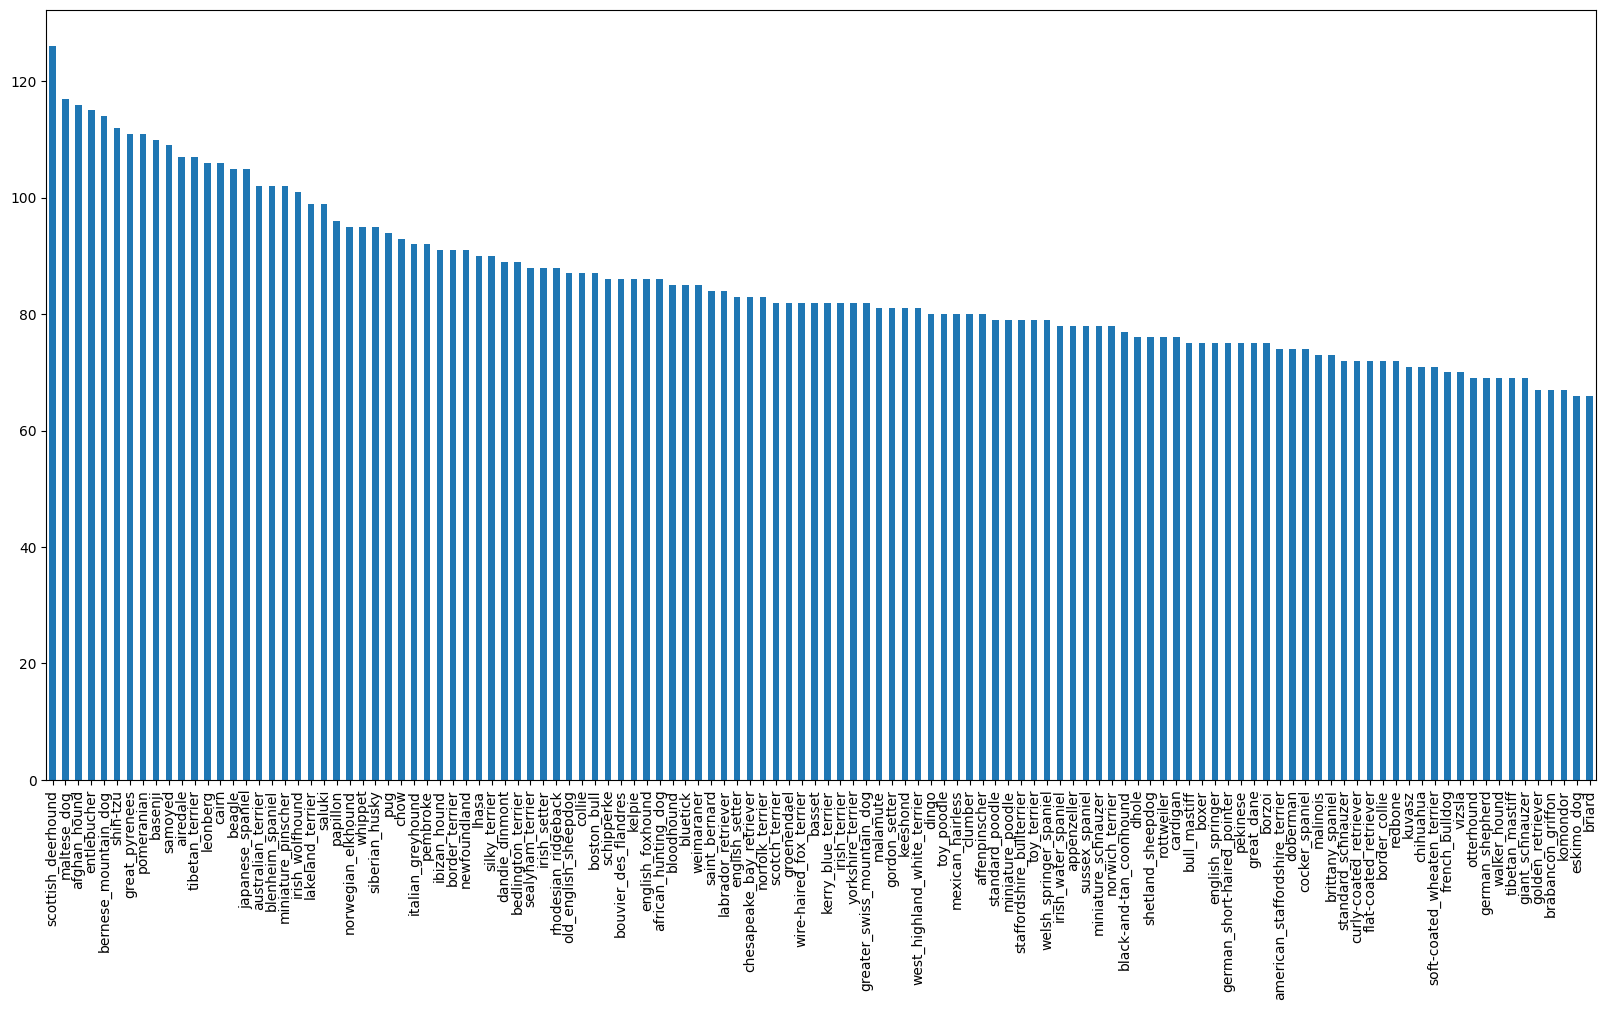

In [ ]:
label_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
filepath=["/content/drive/MyDrive/dog breed/train/"+fname+".jpg" for fname in label_csv['id']]
filepath[0]

'/content/drive/MyDrive/dog breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

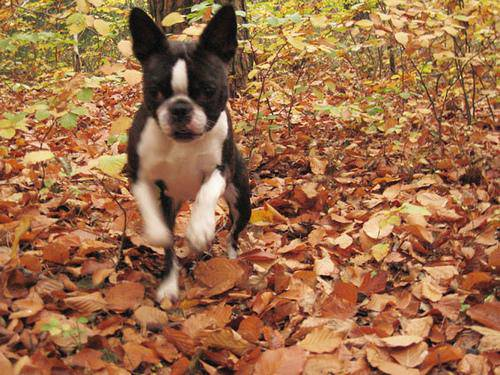

In [ ]:
Image("/content/drive/MyDrive/dog breed/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
labels=label_csv["breed"]
labels=np.array(labels)
labels[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

In [ ]:
unique_breeds=np.unique(labels)
len(unique_breeds)

120

In [ ]:
len(os.listdir('/content/drive/MyDrive/dog breed/train'))

10222

In [ ]:
len(filepath)

10222

In [ ]:
boolean_labels=[label==unique_breeds for label in label_csv["breed"]]
boolean_labels[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
X=filepath
y=boolean_labels

In [ ]:
Num_Images=1000 #@param{type:'slider',min:100,max:1000,steps:100}

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X[:Num_Images],y[:Num_Images],test_size=0.2,random_state=42)
len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [ ]:
IMG_SIZE=224

In [ ]:
def process_image(filepath):
  image=tf.io.read_file(filepath)
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,[IMG_SIZE,IMG_SIZE])
  return image

In [ ]:
def get_image_labels(image,labels):
  image=process_image(image)
  return image,labels

In [ ]:
BATCHSIZE=32
def batchify(X,y=None,batch_size=BATCHSIZE,test_data=False,valid_data=False):
  if test_data:
    print('test data prepared>>>>>>')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch=data.map(process_image).batch(BATCHSIZE)
    return data_batch
  elif valid_data:
    print('validation data prepared>>>>>')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch=data.map(get_image_labels).batch(BATCHSIZE)
    return data_batch
  else:
    print('train data prepared>>>>>>')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data=data.shuffle(buffer_size=len(unique_breeds))
    data_batch=data.map(get_image_labels).batch(BATCHSIZE)
    return data_batch


In [ ]:
train_data=batchify(X=X_train,y=y_train)
val_data=batchify(X=X_val,y=y_val,valid_data=True)

train data prepared>>>>>>
validation data prepared>>>>>


In [ ]:
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE=len(unique_breeds)
URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5"

In [ ]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,url=URL):
  model=Sequential([
      hub.KerasLayer(URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation='softmax')
  ])
  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics='accuracy'
  )
  model.build(INPUT_SHAPE)
  return model

In [ ]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1664)              3766048   
                                                                 
 dense (Dense)               (None, 120)               199800    
                                                                 
Total params: 3,965,848
Trainable params: 199,800
Non-trainable params: 3,766,048
_________________________________________________________________


In [ ]:
EPOCHS=100 #@param{type:"slider",min:10,max:100,steps:10}

In [ ]:
def create_tensorflow_callbacks():
  logdir=os.path.join('/content/drive/MyDrive/dog breed/practicelogs',datetime.datetime.now().strftime("%y%m%d-%h%m%s"))
  return tf.keras.callbacks.TensorBoard(logdir)


In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [ ]:
%load_ext tensorboard

In [ ]:
def train_model():
  model=create_model()
  callbacks=create_tensorflow_callbacks()
  model.fit(x=train_data,
            validation_data=val_data,
            validation_freq=1,
            epochs=EPOCHS,
            callbacks=[callbacks,early_stopping])
  return model

In [ ]:
model=train_model()


Epoch 1/100
25/25 [==============================] - 120s 4s/step - loss: 4.3040 - accuracy: 0.1600 - val_loss: 3.1074 - val_accuracy: 0.3500
Epoch 2/100
25/25 [==============================] - 3s 117ms/step - loss: 1.4030 - accuracy: 0.7912 - val_loss: 1.8580 - val_accuracy: 0.5650
Epoch 3/100
25/25 [==============================] - 3s 118ms/step - loss: 0.5027 - accuracy: 0.9613 - val_loss: 1.4889 - val_accuracy: 0.6450
Epoch 4/100
25/25 [==============================] - 4s 176ms/step - loss: 0.2573 - accuracy: 0.9925 - val_loss: 1.3517 - val_accuracy: 0.6800
Epoch 5/100
25/25 [==============================] - 3s 115ms/step - loss: 0.1636 - accuracy: 0.9975 - val_loss: 1.2740 - val_accuracy: 0.6900
Epoch 6/100
25/25 [==============================] - 3s 117ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 1.2273 - val_accuracy: 0.7050
Epoch 7/100
25/25 [==============================] - 4s 159ms/step - loss: 0.0892 - accuracy: 1.0000 - val_loss: 1.1999 - val_accuracy: 0.7000


In [ ]:
predictions=model.predict(val_data,verbose=1)
predictions


7/7 [==============================] - 1s 95ms/step


array([[1.69482679e-04, 1.00649384e-04, 1.14257820e-03, ...,
        3.22607848e-05, 2.81100583e-05, 5.83063439e-03],
       [5.20922523e-03, 1.64463650e-03, 3.38289849e-02, ...,
        3.10719595e-04, 5.29617816e-03, 4.01912053e-04],
       [2.22696576e-06, 5.35425279e-05, 3.23583299e-05, ...,
        2.11210965e-04, 1.09751800e-05, 4.60248324e-04],
       ...,
       [2.61994296e-06, 6.29936912e-05, 4.50294356e-05, ...,
        4.06097479e-06, 1.53829515e-05, 2.13731983e-04],
       [2.33684946e-03, 1.77270063e-04, 4.22144483e-04, ...,
        1.51467568e-04, 6.89755689e-05, 7.96158053e-03],
       [1.40127173e-04, 1.63209388e-05, 2.70104781e-03, ...,
        6.07144972e-03, 6.60467427e-04, 3.70020425e-05]], dtype=float32)

In [ ]:
index=1
print(np.max(predictions[index]))
print(unique_breeds[np.argmax(predictions[index])])
print(np.argmax(predictions[index]))

0.56215656
scotch_terrier
96


In [ ]:
def get_pred_label(prediction_probablities):
  return unique_breeds[np.argmax(prediction_probablities)]

In [ ]:
def plot_preds(prediction_probablities,labels,images,n=1):
  pred_prob,true_labels,images=prediction_probablities[n],labels[n],images[n]
  pred_labels=get_pred_label(pred_prob)
  plt.imshow(images)
  plt.xticks([])
  plt.yticks([])
  if pred_labels==true_labels:
    color='green'
  else:
    color='red'
  plt.title("{} {:2.0f}% {}".format(pred_labels,np.max(pred_prob)*100,true_labels),color=color)

In [ ]:
def unbatchify(data):
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

In [ ]:
val_images,val_labels=unbatchify(val_data)


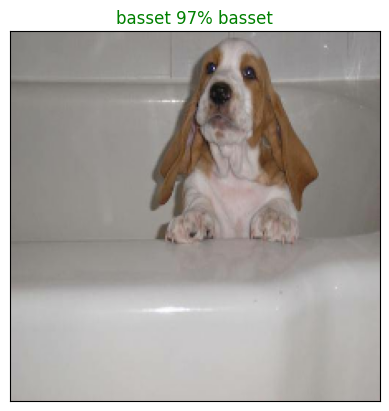

In [ ]:
plot_preds(predictions,labels=val_labels,images=val_images,n=2)

In [ ]:
def plot_bars(prediction_probablities,labels,n=1):
  pred_prob,true_labels=prediction_probablities[n],labels[n]
  pred_labels=get_pred_label(pred_prob)
  top_10_pred_index=pred_prob.argsort()[-10:][::-1]
  top_10_pred_values=pred_prob[top_10_pred_index]
  top_10_pred_labels=unique_breeds[top_10_pred_index]
  top_plot=plt.bar(np.arange(len(top_10_pred_labels)),
                   top_10_pred_values,
                   color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
                  top_10_pred_labels,
                  rotation='vertical')
  if np.isin(true_labels,top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==true_labels)].set_color('green')
  else:
    pass

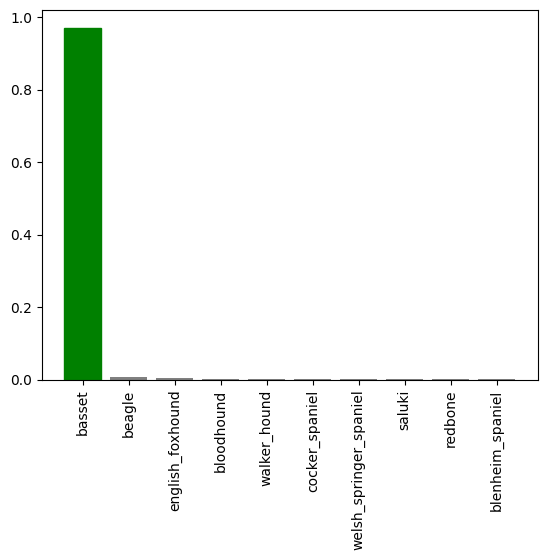

In [ ]:
plot_bars(prediction_probablities=predictions,labels=val_labels,n=2)

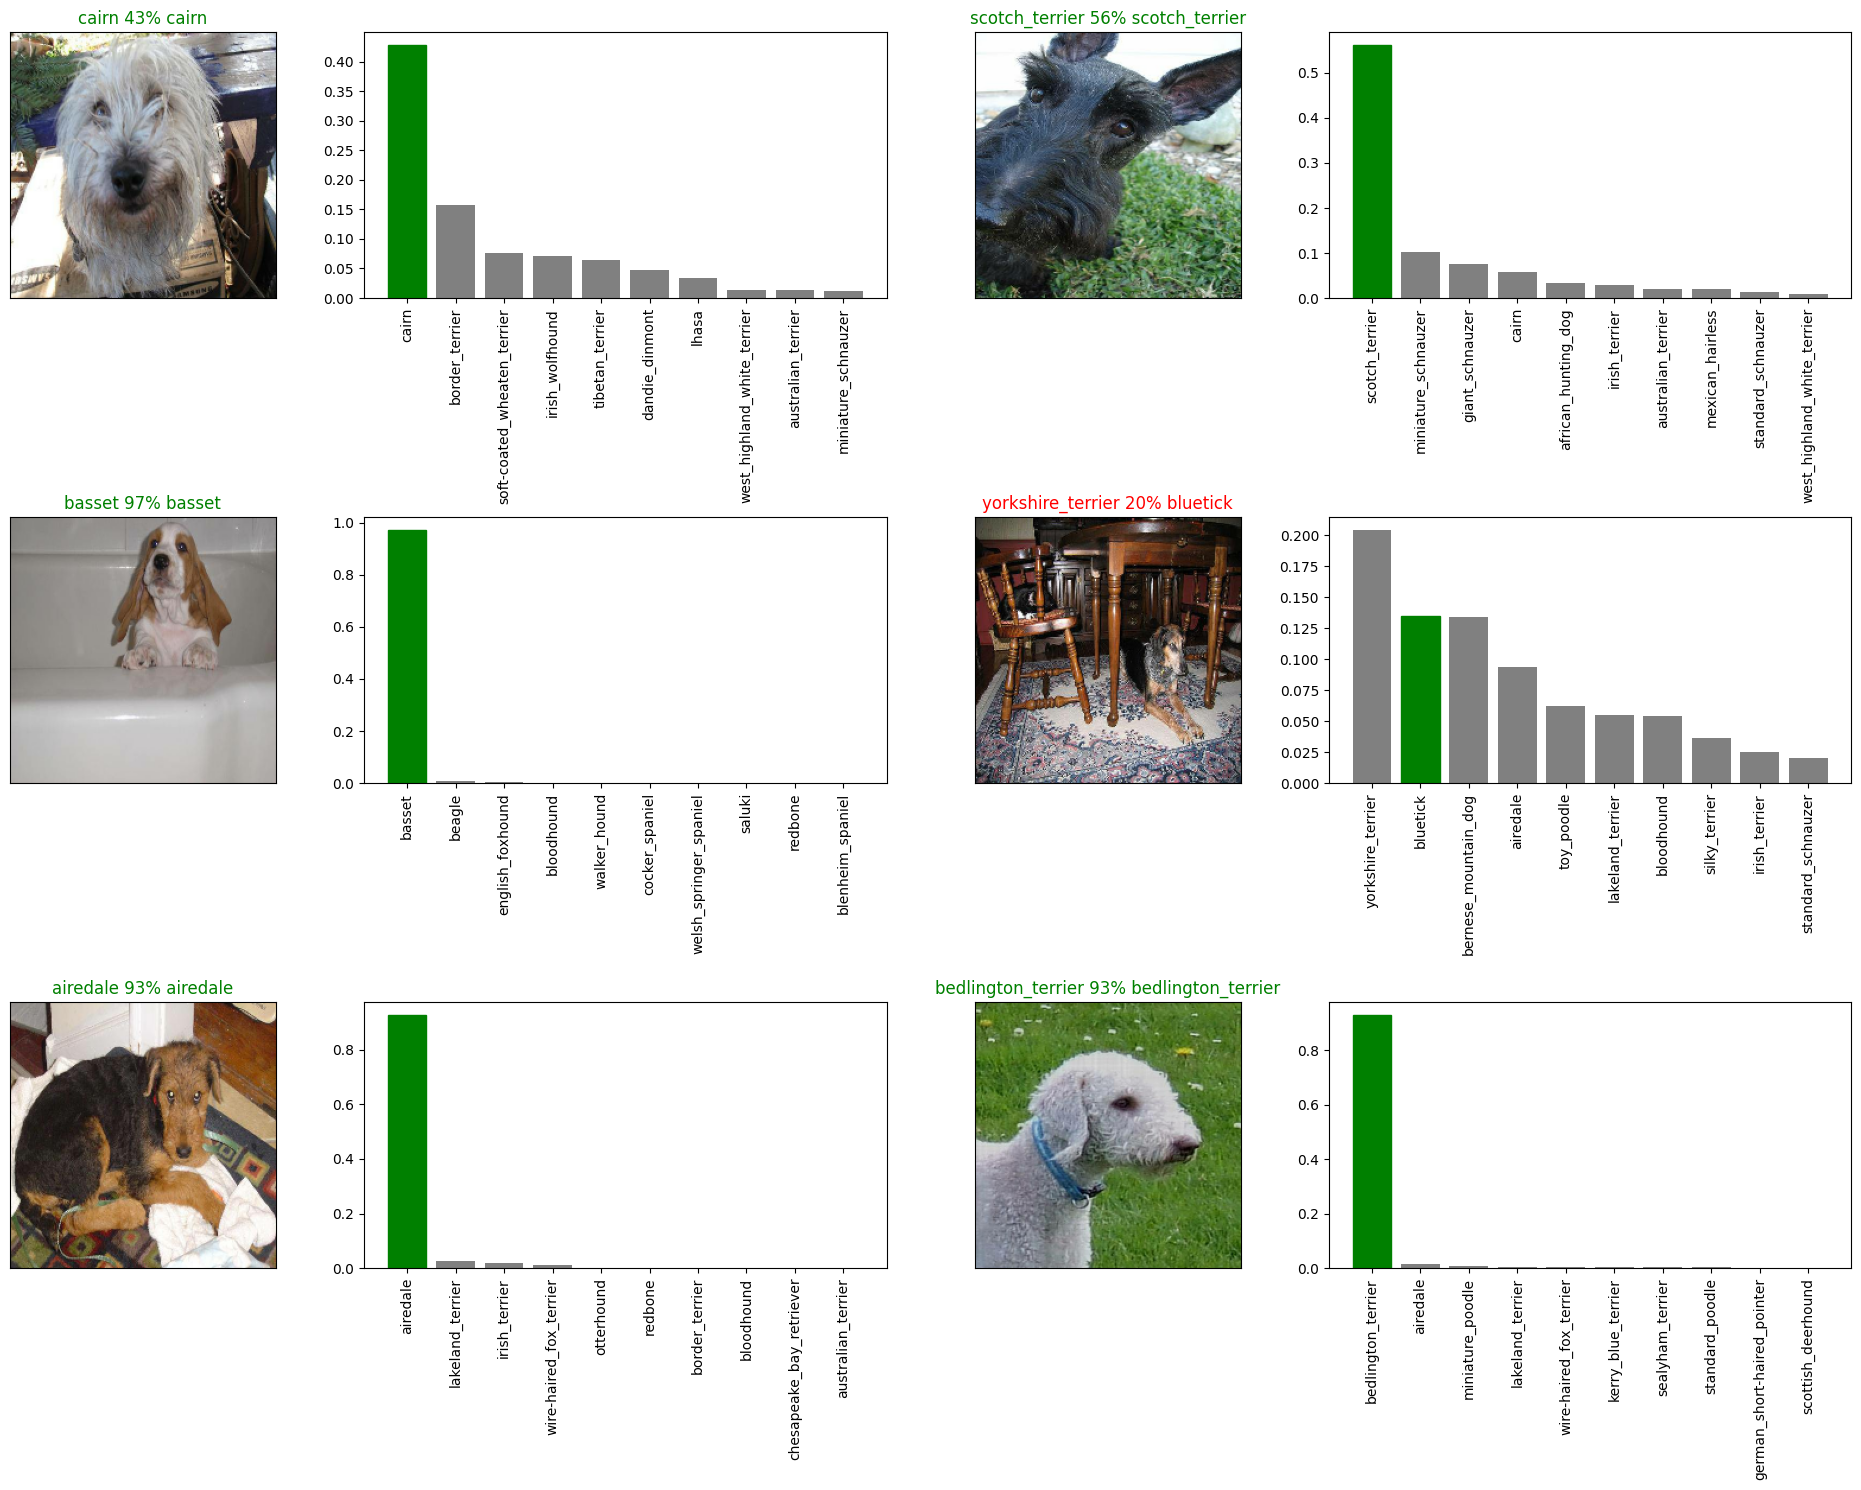

In [ ]:
i_multiplier=0
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_preds(predictions,labels=val_labels,images=val_images,n=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_bars(prediction_probablities=predictions,labels=val_labels,n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)

In [ ]:
def save_model(model,Suffix=None):
  savedir=os.path.join('/content/drive/MyDrive/dog breed/practicemodel',datetime.datetime.now().strftime('%y%m%d-%h%m%s'))
  modelpath=savedir+Suffix+'.h5'
  print(f'model saved to : {modelpath}')
  model.save(modelpath)
  return modelpath

In [ ]:
def load_model(modelpath):
  model=tf.keras.models.load_model(modelpath,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model,Suffix='my_model')

model saved to : /content/drive/MyDrive/dog breed/practicemodel/230908-Sep091694182796my_model.h5


In [ ]:
loaded_model=load_model("/content/drive/MyDrive/dog breed/practicemodel/230908-Sep091694182796my_model.h5")

In [ ]:
loaded_model.evaluate(val_data)

7/7 [==============================] - 2s 102ms/step - loss: 1.1067 - accuracy: 0.7250


[1.1066581010818481, 0.7250000238418579]

In [ ]:
test_path='/content/drive/MyDrive/dog breed/test/'
test_filepath=[test_path+fname for fname in os.listdir(test_path)]
test_filepath[1]

'/content/drive/MyDrive/dog breed/test/e8232c9a79f0e77e9b4c5fca60682d41.jpg'

In [ ]:
test_data=batchify(test_filepath,test_data=True)

test data prepared>>>>>>


In [ ]:
test_predictions=loaded_model.predict(test_data,verbose=1)

324/324 [==============================] - 1469s 5s/step


In [ ]:
np.savetxt('/content/drive/MyDrive/dog breed/practice.csv',test_predictions,delimiter=",")

In [ ]:
test_predictions=np.loadtxt('/content/drive/MyDrive/dog breed/practice.csv',delimiter=",")

In [ ]:
preds_df=pd.DataFrame(columns=['id']+list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
test_id=[os.path.splitext(path) for path in os.listdir(test_path)]
preds_df['id']=test_id

In [ ]:
preds_df[list(unique_breeds)]=test_predictions
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,"(e73d52671c56e1507fed58c4c287d5f1, .jpg)",0.000218,0.000261,0.000081,1.402959e-04,0.000054,3.608283e-02,0.000043,0.000233,0.000033,...,0.000270,0.000011,0.000034,0.000049,2.159607e-06,0.000497,0.000017,0.000018,2.986821e-05,0.000110
1,"(e8232c9a79f0e77e9b4c5fca60682d41, .jpg)",0.000005,0.001887,0.000044,1.671709e-05,0.000022,1.349620e-06,0.000032,0.000003,0.000449,...,0.000043,0.000002,0.000042,0.000374,6.234150e-05,0.000005,0.000002,0.000023,1.963074e-04,0.000059
2,"(e7f95aabf775a636b3893ffa120adaf9, .jpg)",0.241455,0.000218,0.000168,9.000162e-05,0.000316,2.359455e-05,0.004180,0.000104,0.000052,...,0.002429,0.000071,0.000046,0.000022,2.205574e-05,0.000063,0.000073,0.000014,2.344316e-06,0.005070
3,"(e7afcce6e45858fc3b294cc5c0b15a53, .jpg)",0.515683,0.002051,0.000678,4.159238e-04,0.000008,8.496289e-07,0.002895,0.000088,0.000005,...,0.000635,0.000013,0.000039,0.000002,1.316823e-05,0.000016,0.000022,0.000005,4.040535e-06,0.003360
4,"(e732916519751eaa0cb2ba0cc1217ab9, .jpg)",0.000047,0.000126,0.000014,7.663413e-07,0.000006,3.058307e-06,0.000058,0.000040,0.001742,...,0.000448,0.000022,0.000004,0.000041,4.652832e-07,0.027129,0.000006,0.000008,1.439838e-06,0.000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,"(07ad1a0d014793de8c2e104b801c6cda, .jpg)",0.000242,0.000291,0.000103,4.369106e-01,0.001084,6.114058e-04,0.005719,0.000038,0.000117,...,0.000358,0.000040,0.001685,0.000316,2.974185e-04,0.000053,0.000042,0.000352,1.069869e-01,0.000674
10353,"(077b4c62007a362be52711169abfa4fd, .jpg)",0.000329,0.000085,0.000360,1.815561e-05,0.000101,1.368861e-05,0.000096,0.000817,0.003340,...,0.000627,0.002776,0.001085,0.006354,1.155923e-04,0.071283,0.000009,0.000466,3.201910e-04,0.000167
10354,"(07d5ab48d42c8e67b8720ae221ad1962, .jpg)",0.000351,0.000019,0.000256,1.411970e-06,0.000321,3.319267e-06,0.000010,0.000792,0.000029,...,0.000245,0.000556,0.000001,0.000043,4.850612e-06,0.000015,0.000008,0.000060,7.511354e-07,0.000008
10355,"(0821ea02386d4a714d7b6e39ee5e66e8, .jpg)",0.000255,0.000519,0.003252,1.422722e-01,0.000161,1.008172e-04,0.006271,0.016104,0.000359,...,0.003786,0.000687,0.000677,0.000152,8.738742e-05,0.000111,0.001549,0.000334,8.114417e-03,0.038974


In [ ]:
preds_df.to_csv('/content/drive/MyDrive/dog breed/newmodel.csv',index=False)